In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import time

In [2]:

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load the dataset
# Note: Assuming the dataset is available as 'laptop_data.csv'
df = pd.read_csv('FinalDataset.csv')


# Prepare features and target
X = df.drop('Price', axis=1).values
y = df['Price'].values

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to torch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y).view(-1, 1)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_tensor = torch.FloatTensor(X_train).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1).to(device)
y_test_tensor = torch.FloatTensor(y_test).view(-1, 1).to(device)

# Create tensor datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Define the neural network model class
class LaptopPriceNN(nn.Module):
    def __init__(self, input_size, hidden_layers, dropout_rate=0.2):
        """
        Initialize the neural network

        Parameters:
        -----------
        input_size : int
            Number of input features
        hidden_layers : list
            List of neurons per hidden layer
        dropout_rate : float
            Dropout rate for regularization
        """
        super(LaptopPriceNN, self).__init__()

        # Create layers list
        layers = []

        # Input layer
        prev_size = input_size

        # Create hidden layers
        for i, size in enumerate(hidden_layers):
            layers.append(nn.Linear(prev_size, size))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(size))
            layers.append(nn.Dropout(dropout_rate))
            prev_size = size

        # Output layer
        layers.append(nn.Linear(prev_size, 1))

        # Create sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        """Forward pass"""
        if x.size(0) == 1:
            # Switch to eval mode temporarily for batch size of 1
            training_status = self.training
            self.eval()
            out = self.model(x)
            if training_status:
                self.train()
            return out
        return self.model(x)

# Modified model architecture to allow different activation functions
class LaptopPriceMixedNN(nn.Module):
    def __init__(self, input_size, hidden_layers, activations, dropout_rate=0.2):
        """
        Initialize the neural network with custom activations

        Parameters:
        -----------
        input_size : int
            Number of input features
        hidden_layers : list
            List of neurons per hidden layer
        activations : list
            List of activation function names ('relu', 'elu', 'leaky_relu', 'tanh')
        dropout_rate : float
            Dropout rate for regularization
        """
        super(LaptopPriceMixedNN, self).__init__()

        # Create layers list
        layers = []

        # Input layer
        prev_size = input_size

        # Create hidden layers
        for i, (size, activation) in enumerate(zip(hidden_layers, activations)):
            layers.append(nn.Linear(prev_size, size))

            # Add activation function
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'elu':
                layers.append(nn.ELU())
            elif activation == 'leaky_relu':
                layers.append(nn.LeakyReLU())
            elif activation == 'tanh':
                layers.append(nn.Tanh())

            layers.append(nn.BatchNorm1d(size))
            layers.append(nn.Dropout(dropout_rate))
            prev_size = size

        # Output layer
        layers.append(nn.Linear(prev_size, 1))

        # Create sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        """Forward pass"""
        if x.size(0) == 1:
            # Switch to eval mode temporarily for batch size of 1
            training_status = self.training
            self.eval()
            out = self.model(x)
            if training_status:
                self.train()
            return out
        return self.model(x)

# Function to train a model
def train_model(model, train_loader, val_loader, criterion, optimizer,
                epochs=200, patience=30, verbose=True):
    """
    Train the PyTorch model

    Parameters:
    -----------
    model : nn.Module
        PyTorch model
    train_loader : DataLoader
        DataLoader for training data
    val_loader : DataLoader
        DataLoader for validation data
    criterion : nn.Module
        Loss function
    optimizer : optim.Optimizer
        Optimizer
    epochs : int
        Maximum number of epochs
    patience : int
        Patience for early stopping
    verbose : bool
        Whether to print training progress

    Returns:
    --------
    model : nn.Module
        Trained model
    history : dict
        Training history
    """

    model.to(device)

    # For tracking training progress
    history = {
        'train_loss': [],
        'val_loss': [],
        'best_epoch': 0,
        'epochs_trained': 0
    }

    # For early stopping
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_state_dict = None

    # Training loop
    start_time = time.time()

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0

        for inputs, targets in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_loader.dataset)
        history['train_loss'].append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)

        val_loss /= len(val_loader.dataset)
        history['val_loss'].append(val_loss)

        # Print progress
        if verbose and epoch % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} - "
                  f"Train Loss: {train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_state_dict = model.state_dict().copy()
            history['best_epoch'] = epoch
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                if verbose:
                    print(f"Early stopping triggered after {epoch+1} epochs")
                break

    # Record how many epochs were trained
    history['epochs_trained'] = epoch + 1

    # Load the best model
    model.load_state_dict(best_state_dict)

    # Record training time
    history['training_time'] = time.time() - start_time

    return model, history

# Function to evaluate a model
def evaluate_model(model, X_test_tensor, y_test_tensor):
    """
    Evaluate the model on test data

    Parameters:
    -----------
    model : nn.Module
        PyTorch model
    X_test_tensor : Tensor
        Test features
    y_test_tensor : Tensor
        Test targets

    Returns:
    --------
    results : dict
        Dictionary containing evaluation metrics
    """

    model.eval()

    with torch.no_grad():
        y_pred = model(X_test_tensor)

    # Convert tensors to numpy arrays
    y_true = y_test_tensor.cpu().numpy()
    y_pred = y_pred.cpu().numpy()

    # Calculate metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return {
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

# Function to build, train and evaluate a model
def build_train_evaluate_model(hidden_layers, batch_size=8, learning_rate=0.001,
                              epochs=200, dropout_rate=0.2, patience=30):
    """
    Build, train and evaluate a model with the specified parameters

    Parameters:
    -----------
    hidden_layers : list
        List of neurons per hidden layer
    batch_size : int
        Batch size for training
    learning_rate : float
        Learning rate for optimizer
    epochs : int
        Maximum number of epochs
    dropout_rate : float
        Dropout rate for regularization
    patience : int
        Patience for early stopping

    Returns:
    --------
    model : nn.Module
        Trained model
    history : dict
        Training history
    results : dict
        Evaluation results
    """

    # Create data loaders
    train_val_split = int(0.8 * len(X_train_tensor))
    train_subset, val_subset = torch.utils.data.random_split(
        train_dataset, [train_val_split, len(X_train_tensor) - train_val_split]
    )

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size)

    # Create model
    model = LaptopPriceNN(X_train_tensor.shape[1], hidden_layers, dropout_rate)

    # Create loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train model
    model, history = train_model(
        model, train_loader, val_loader, criterion, optimizer,
        epochs=epochs, patience=patience, verbose=False
    )

    # Evaluate model
    results = evaluate_model(model, X_test_tensor, y_test_tensor)

    # Add training history to results
    results.update({
        'training_time': history['training_time'],
        'epochs_trained': history['epochs_trained']
    })

    return model, history, results

# Function to build, train and evaluate a model with custom activations
def build_train_evaluate_mixed_model(hidden_layers, activations, batch_size=8,
                                    learning_rate=0.001, epochs=200,
                                    dropout_rate=0.2, patience=30):
    """
    Build, train and evaluate a model with custom activations

    Parameters:
    -----------
    hidden_layers : list
        List of neurons per hidden layer
    activations : list
        List of activation function names
    batch_size : int
        Batch size for training
    learning_rate : float
        Learning rate for optimizer
    epochs : int
        Maximum number of epochs
    dropout_rate : float
        Dropout rate for regularization
    patience : int
        Patience for early stopping

    Returns:
    --------
    model : nn.Module
        Trained model
    history : dict
        Training history
    results : dict
        Evaluation results
    """

    # Create data loaders
    train_val_split = int(0.8 * len(X_train_tensor))
    train_subset, val_subset = torch.utils.data.random_split(
        train_dataset, [train_val_split, len(X_train_tensor) - train_val_split]
    )

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size)

    # Create model
    model = LaptopPriceMixedNN(X_train_tensor.shape[1], hidden_layers, activations, dropout_rate)

    # Create loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train model
    model, history = train_model(
        model, train_loader, val_loader, criterion, optimizer,
        epochs=epochs, patience=patience, verbose=False
    )

    # Evaluate model
    results = evaluate_model(model, X_test_tensor, y_test_tensor)

    # Add training history to results
    results.update({
        'training_time': history['training_time'],
        'epochs_trained': history['epochs_trained']
    })

    return model, history, results

# Function to implement k-fold cross-validation
def cross_validate_model(hidden_layers, activations=None, n_splits=5, batch_size=8,
                         learning_rate=0.001, epochs=100, dropout_rate=0.2, patience=20):
    """
    Perform cross-validation on the model

    Parameters:
    -----------
    hidden_layers : list
        List of neurons per hidden layer
    activations : list or None
        List of activation function names, if None, use ReLU for all layers
    n_splits : int
        Number of folds for cross-validation
    batch_size : int
        Batch size for training
    learning_rate : float
        Learning rate for optimizer
    epochs : int
        Maximum number of epochs
    dropout_rate : float
        Dropout rate for regularization
    patience : int
        Patience for early stopping

    Returns:
    --------
    results : dict
        Dictionary containing average evaluation metrics across folds
    """

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    rmse_scores = []
    mae_scores = []
    r2_scores = []
    training_times = []



    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"Training on fold {fold+1}/{n_splits}...")

        # Split data
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        # Convert to tensors
        X_train_fold_tensor = torch.FloatTensor(X_train_fold).to(device)
        X_val_fold_tensor = torch.FloatTensor(X_val_fold).to(device)
        y_train_fold_tensor = torch.FloatTensor(y_train_fold).view(-1, 1).to(device)
        y_val_fold_tensor = torch.FloatTensor(y_val_fold).view(-1, 1).to(device)

        # Create datasets and loaders
        train_fold_dataset = TensorDataset(X_train_fold_tensor, y_train_fold_tensor)
        train_loader = DataLoader(train_fold_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val_fold_tensor, y_val_fold_tensor), batch_size=batch_size)

        # Create model
        if activations is None:
            activations = ['relu'] * len(hidden_layers)
            model = LaptopPriceNN(X_train_fold_tensor.shape[1], hidden_layers, dropout_rate)
        else:
            model = LaptopPriceMixedNN(X_train_fold_tensor.shape[1], hidden_layers, activations, dropout_rate)

        # Create loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Train model
        model, history = train_model(
            model, train_loader, val_loader, criterion, optimizer,
            epochs=epochs, patience=patience, verbose=False
        )

        # Evaluate model
        model.eval()
        with torch.no_grad():
            y_pred = model(X_val_fold_tensor)

        # Convert tensors to numpy arrays
        y_true = y_val_fold_tensor.cpu().numpy()
        y_pred = y_pred.cpu().numpy()

        # Calculate metrics
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        rmse_scores.append(rmse)
        mae_scores.append(mae)
        r2_scores.append(r2)
        training_times.append(history['training_time'])

    results = {
        'rmse_mean': np.mean(rmse_scores),
        'rmse_std': np.std(rmse_scores),
        'mae_mean': np.mean(mae_scores),
        'mae_std': np.std(mae_scores),
        'r2_mean': np.mean(r2_scores),
        'r2_std': np.std(r2_scores),
        'training_time_mean': np.mean(training_times)
    }

    return results

# Define model architectures to test
architectures = [
    {
        'name': 'Simple (16)',
        'hidden_layers': [16],
    },
    {
        'name': 'Medium (32, 16)',
        'hidden_layers': [32, 16],
    },
    {
        'name': 'Deep (64, 32, 16)',
        'hidden_layers': [64, 32, 16],
    },
    {
        'name': 'Wide (128, 64)',
        'hidden_layers': [128, 64],
    },
    {
        'name': 'Complex (64, 32, 16, 8)',
        'hidden_layers': [64, 32, 16, 8],
    }
]

# Define mixed activation architectures
mixed_architectures = [
    {
        'name': 'Mixed ReLU+ELU (64, 32, 16)',
        'hidden_layers': [64, 32, 16],
        'activations': ['relu', 'elu', 'relu']
    },
    {
        'name': 'Mixed ReLU+LeakyReLU (64, 32, 16)',
        'hidden_layers': [64, 32, 16],
        'activations': ['relu', 'leaky_relu', 'relu']
    },
    {
        'name': 'Mixed ReLU+Tanh (64, 32, 16)',
        'hidden_layers': [64, 32, 16],
        'activations': ['relu', 'tanh', 'relu']
    }
]

# Test different dropout rates
dropout_rates = [0.1, 0.2, 0.3]

# Dictionary to store results
results = {}

# Train and evaluate standard architectures
print("Training standard architectures...")
for arch in architectures:
    for dr in dropout_rates:
        model_name = f"{arch['name']} (dropout={dr})"
        print(f"Training {model_name}...")

        # Train and evaluate model
        model, history, result = build_train_evaluate_model(
            hidden_layers=arch['hidden_layers'],
            dropout_rate=dr
        )

        results[model_name] = result
        print(f"  RMSE: {result['rmse']:.2f}, MAE: {result['mae']:.2f}, R²: {result['r2']:.4f}")

# Train and evaluate mixed activation architectures
print("\nTraining mixed activation architectures...")
for arch in mixed_architectures:
    for dr in [0.2]:  # Use middle dropout rate for mixed activation architectures
        model_name = f"{arch['name']} (dropout={dr})"
        print(f"Training {model_name}...")

        # Train and evaluate model
        model, history, result = build_train_evaluate_mixed_model(
            hidden_layers=arch['hidden_layers'],
            activations=arch['activations'],
            dropout_rate=dr
        )

        results[model_name] = result
        print(f"  RMSE: {result['rmse']:.2f}, MAE: {result['mae']:.2f}, R²: {result['r2']:.4f}")

# Find the best model
best_model_name = min(results, key=lambda k: results[k]['rmse'])
best_model_rmse = results[best_model_name]['rmse']
best_model_r2 = results[best_model_name]['r2']

print(f"\nBest model: {best_model_name}")
print(f"RMSE: {best_model_rmse:.2f}")
print(f"R²: {best_model_r2:.4f}")


Using device: cpu
Training standard architectures...
Training Simple (16) (dropout=0.1)...
  RMSE: 13662.50, MAE: 10127.61, R²: 0.2900
Training Simple (16) (dropout=0.2)...
  RMSE: 13458.81, MAE: 9698.23, R²: 0.3110
Training Simple (16) (dropout=0.3)...
  RMSE: 15194.78, MAE: 11878.90, R²: 0.1218
Training Medium (32, 16) (dropout=0.1)...
  RMSE: 11907.75, MAE: 8952.05, R²: 0.4607
Training Medium (32, 16) (dropout=0.2)...
  RMSE: 12211.82, MAE: 9364.36, R²: 0.4328
Training Medium (32, 16) (dropout=0.3)...
  RMSE: 16688.81, MAE: 13530.09, R²: -0.0594
Training Deep (64, 32, 16) (dropout=0.1)...
  RMSE: 12720.31, MAE: 10084.35, R²: 0.3845
Training Deep (64, 32, 16) (dropout=0.2)...
  RMSE: 13866.50, MAE: 11219.38, R²: 0.2686
Training Deep (64, 32, 16) (dropout=0.3)...
  RMSE: 14179.36, MAE: 11161.56, R²: 0.2353
Training Wide (128, 64) (dropout=0.1)...
  RMSE: 7672.10, MAE: 4191.66, R²: 0.7761
Training Wide (128, 64) (dropout=0.2)...
  RMSE: 8230.57, MAE: 4208.85, R²: 0.7423
Training Wide (

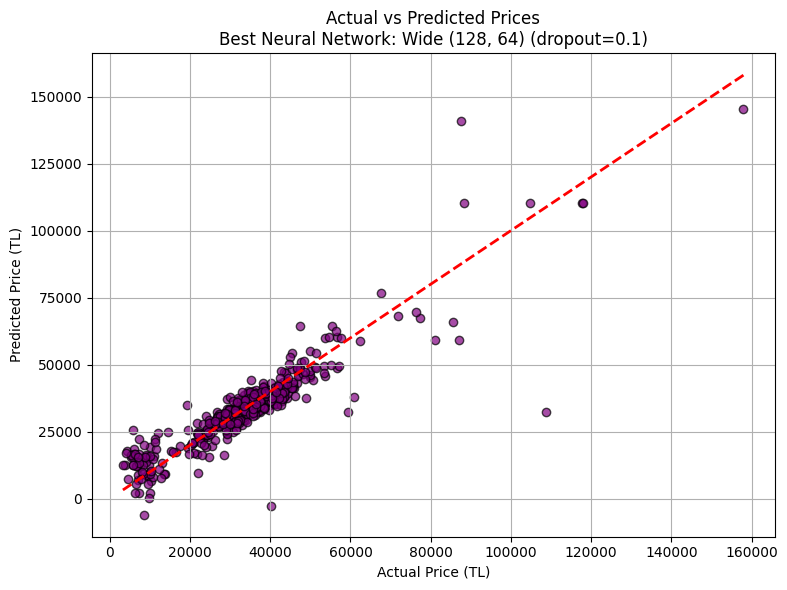

In [4]:
# Plot actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_true_best, y_pred_best, alpha=0.7, color='purple', edgecolor='k')
plt.plot([y_true_best.min(), y_true_best.max()], [y_true_best.min(), y_true_best.max()], 'r--', lw=2)
plt.xlabel("Actual Price (TL)")
plt.ylabel("Predicted Price (TL)")
plt.title(f"Actual vs Predicted Prices\nBest Neural Network: {best_model_name}")
plt.grid(True)
plt.tight_layout()
plt.show()